In [1]:
import os
import argparse

os.chdir('/opt/ml/P-Stage/1-STAGE/pstage_01_image_classification/')

In [2]:
parser = argparse.ArgumentParser()

# Data and model checkpoints directories
parser.add_argument(
    "--dataset",
    type=str,
    default="MaskBaseDataset",
    help="dataset augmentation type (default: MaskBaseDataset)",
)
parser.add_argument(
    "--augmentation",
    type=str,
    default="BaseAugmentation",
    help="data augmentation type (default: BaseAugmentation)",
)
parser.add_argument(
    "--resize",
    nargs="+",
    type=list,
    default=[128, 96],
    help="resize size for image when training",
)
parser.add_argument(
    "--batch_size",
    type=int,
    default=64,
    help="input batch size for training (default: 64)",
)
parser.add_argument(
    "--valid_batch_size",
    type=int,
    default=1000,
    help="input batch size for validing (default: 1000)",
)
parser.add_argument(
    "--model", type=str, default="BaseModel", help="model type (default: BaseModel)"
)

# Container environment
parser.add_argument(
    "--data_dir",
    type=str,
    default=os.environ.get("SM_CHANNEL_TRAIN", "/opt/ml/input/data/train/images"),
)
parser.add_argument(
    "--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR", "./model")
)

args = parser.parse_args(args=[])

In [3]:
import os
import re
import glob
import json
import random
import argparse
import warnings
from pathlib import Path
from importlib import import_module

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Subset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from loss import create_criterion
from dataset import MaskBaseDataset

warnings.filterwarnings(action="ignore")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -- dataset
dataset_module = getattr(
    import_module("dataset"), args.dataset
)  # default: BaseAugmentation
dataset = dataset_module(data_dir=args.data_dir)
num_classes = dataset.num_classes  # 18

# -- augmentation
transform_module = getattr(
    import_module("dataset"), args.augmentation
)  # default: BaseAugmentation

transform = transform_module(resize=args.resize, mean=dataset.mean, std=dataset.std)
dataset.set_transform(transform)

# -- data_loader
_, val_set = dataset.split_dataset()

val_loader = DataLoader(
    val_set,
    num_workers=4,
    shuffle=False,
    drop_last=True,
    batch_size=args.valid_batch_size,
    pin_memory=torch.cuda.is_available(),
)

In [5]:
def get_all_datas(model, device, dataloader, argmax=True):
    """ dataloader의 모든 data들을 가져온다. """
    model.eval()
    
    all_images = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)

    with torch.no_grad():
        for idx, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            preds = model(images)
            if argmax:
                preds = torch.argmax(preds, dim=1)
                preds = change_2d_to_1d(preds)

            all_images = torch.cat((all_images, images))
            all_labels = torch.cat((all_labels, labels))
            all_preds = torch.cat((all_preds, preds))

    return all_images, all_labels, all_preds

In [6]:
model_module = getattr(import_module("model"), args.model)  # default: BaseModel
model = model_module(num_classes=num_classes).to(device)
model = torch.nn.DataParallel(model)

In [7]:
images, labels, preds = get_all_datas(model, device, val_loader, argmax=False)

In [8]:
images.shape, labels.shape, preds.shape

(torch.Size([3000, 3, 128, 96]), torch.Size([3000]), torch.Size([3000, 18]))

## BaseCode

In [9]:
def change_2d_to_1d(tensor_2d):
    if len(tensor_2d.shape) == 2:
        tensor_2d = tensor_2d.reshape(-1)
    return tensor_2d


def tensor_images_to_numpy_images(images, renormalize=False):
    images = images.detach().cpu().numpy()
    if renormalize:
        images = np.clip((images * STD) + MEAN, 0, 1)
    images = images.transpose(0, 2, 3, 1)
    return images


def tensor_to_numpy(tensors):
    return tensors.detach().cpu().numpy()

In [10]:
labels, preds = tensor_to_numpy(labels), tensor_to_numpy(preds)

In [11]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def log_f1_and_acc_scores(labels, preds, num_classes):
    # class 별 f1_score를 계산해야함.

    summary_table = pd.DataFrame([])

    for class_idx in range(num_classes):
        fancy_idx = np.where(labels == class_idx)

        binary_labels = labels[fancy_idx] == class_idx
        binary_outputs = preds[fancy_idx] == class_idx

        f1 = f1_score(binary_labels, binary_outputs, average="binary")
        pr = precision_score(binary_labels, binary_outputs, average="binary")
        re = recall_score(binary_labels, binary_outputs, average="binary")
        acc = accuracy_score(binary_labels, binary_outputs)

        summary_table.loc["1003", f"{class_idx} f1"] = f1
        summary_table.loc["1003", f"{class_idx} pr"] = pr
        summary_table.loc["1003", f"{class_idx} re"] = re
        summary_table.loc["1003", f"{class_idx} acc"] = acc
    
    summary_table.fillna(0, inplace=True)
    summary_table = summary_table.applymap(lambda x: "{:,.1f}%".format(x * 100))
    
    return summary_table

In [12]:
df = log_f1_and_acc_scores(labels, np.argmax(preds, axis=1), num_classes)

In [13]:
df  # class 18개는 보기가 살짝 힘듭니다.

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc,3 f1,3 pr,3 re,3 acc,4 f1,4 pr,4 re,4 acc,5 f1,5 pr,5 re,5 acc,6 f1,6 pr,6 re,6 acc,7 f1,7 pr,7 re,7 acc,8 f1,8 pr,8 re,8 acc,9 f1,9 pr,9 re,9 acc,10 f1,10 pr,10 re,10 acc,11 f1,11 pr,11 re,11 acc,12 f1,12 pr,12 re,12 acc,13 f1,13 pr,13 re,13 acc,14 f1,14 pr,14 re,14 acc,15 f1,15 pr,15 re,15 acc,16 f1,16 pr,16 re,16 acc,17 f1,17 pr,17 re,17 acc
1003,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,73.3%,100.0%,57.8%,57.8%,58.1%,100.0%,40.9%,40.9%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,1.5%,100.0%,0.8%,0.8%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


## Confusion Matrix

In [14]:
import itertools
from sklearn.metrics import confusion_matrix

def log_confusion_matrix(labels, preds, num_classes):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
    fig.suptitle("Confusion Matrix", fontsize=16)
    cmap = plt.cm.Oranges

    cm = confusion_matrix(labels, preds)
    
    axes[0].imshow(cm, interpolation="nearest", cmap=cmap)

    axes[0].set_xticks(range(num_classes))
    axes[0].set_yticks(range(num_classes))
    axes[0].set_ylabel("True label")
    axes[0].set_xlabel("Predicted label")

    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axes[0].text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    np.fill_diagonal(cm, 0)
    axes[1].imshow(cm, interpolation="nearest", cmap=cmap)

    axes[1].set_xticks(range(num_classes))
#     axes[1].set_xticklabels(classes)
    axes[1].set_yticks([])
    axes[1].set_xlabel("Predicted label")

    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axes[1].text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    return fig

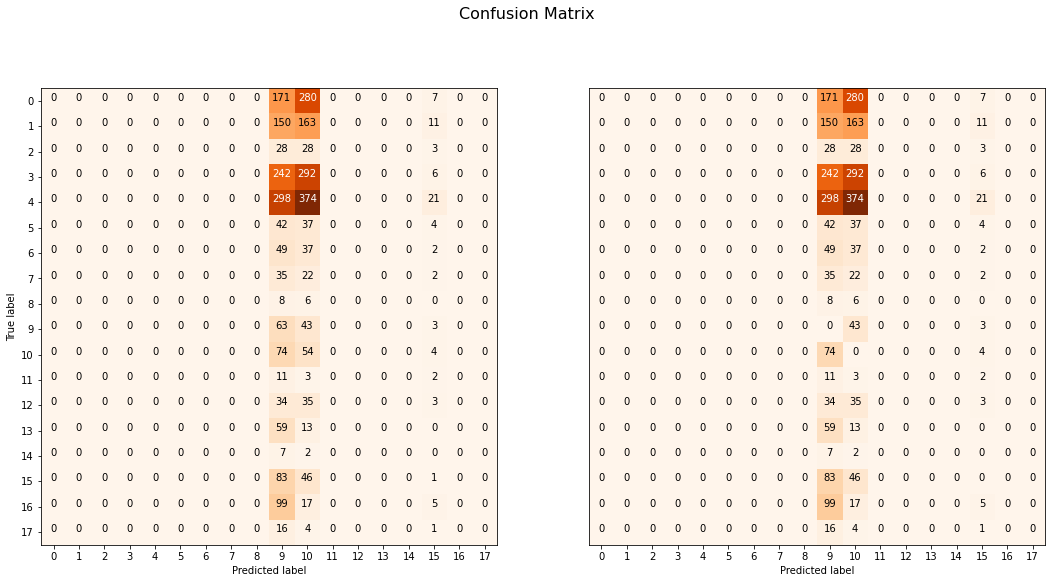

In [15]:
fig = log_confusion_matrix(labels, np.argmax(preds, axis=1), num_classes)

## Plot Results

In [16]:
from scipy.special import softmax

MEAN = np.array([0.548, 0.504, 0.479]).reshape(-1, 1, 1)
STD = np.array([0.237, 0.247, 0.246]).reshape(-1, 1, 1)

        
def _log_plots_image(ax, image, pred, pred_label, true_label, num_classes):
    ax.grid(False)
    color = "blue" if pred_label == true_label else "red"
    
    classes = np.array([str(i) for i in range(num_classes)])
    
    ax.imshow(image)
    ax.set_xlabel(
        "pred: {} {:2.0f}% | (true: {})".format(
            classes[pred_label], 100 * pred[pred_label], classes[true_label]
        ),
        color=color,
    )

def _log_plots_distribution(ax, pred, pred_label, true_label, num_classes):
    ax.grid(False)
    ax.set_ylim([0, 1])

    thisplot = ax.bar(range(num_classes), pred, color="#777777")

    thisplot[pred_label].set_color("red")
    thisplot[true_label].set_color("blue")


def plots_result(images, labels, preds, num_classes, title="plots_result"):
    """ all inputs are numpy """

    preds = softmax(preds, axis=1)

    num_rows = num_cols = int(len(images) ** 0.5)
    num_images = num_rows * num_cols
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols * 2, figsize=(36, 18))
    fig.suptitle(title, fontsize=54)

    plt.setp(axes, xticks=[], yticks=[])

    for idx in range(num_images):
        image, pred, label = images[idx], preds[idx], labels[idx]

        num_row = idx // num_rows
        num_col = idx % num_cols

        pred_label = np.argmax(pred)
        true_label = label

        _log_plots_image(
            axes[num_row][num_col * 2], image, pred, pred_label, true_label, num_classes
        )

        _log_plots_distribution(
            axes[num_row][num_col * 2 + 1], pred, pred_label, true_label, num_classes
        )

    return fig

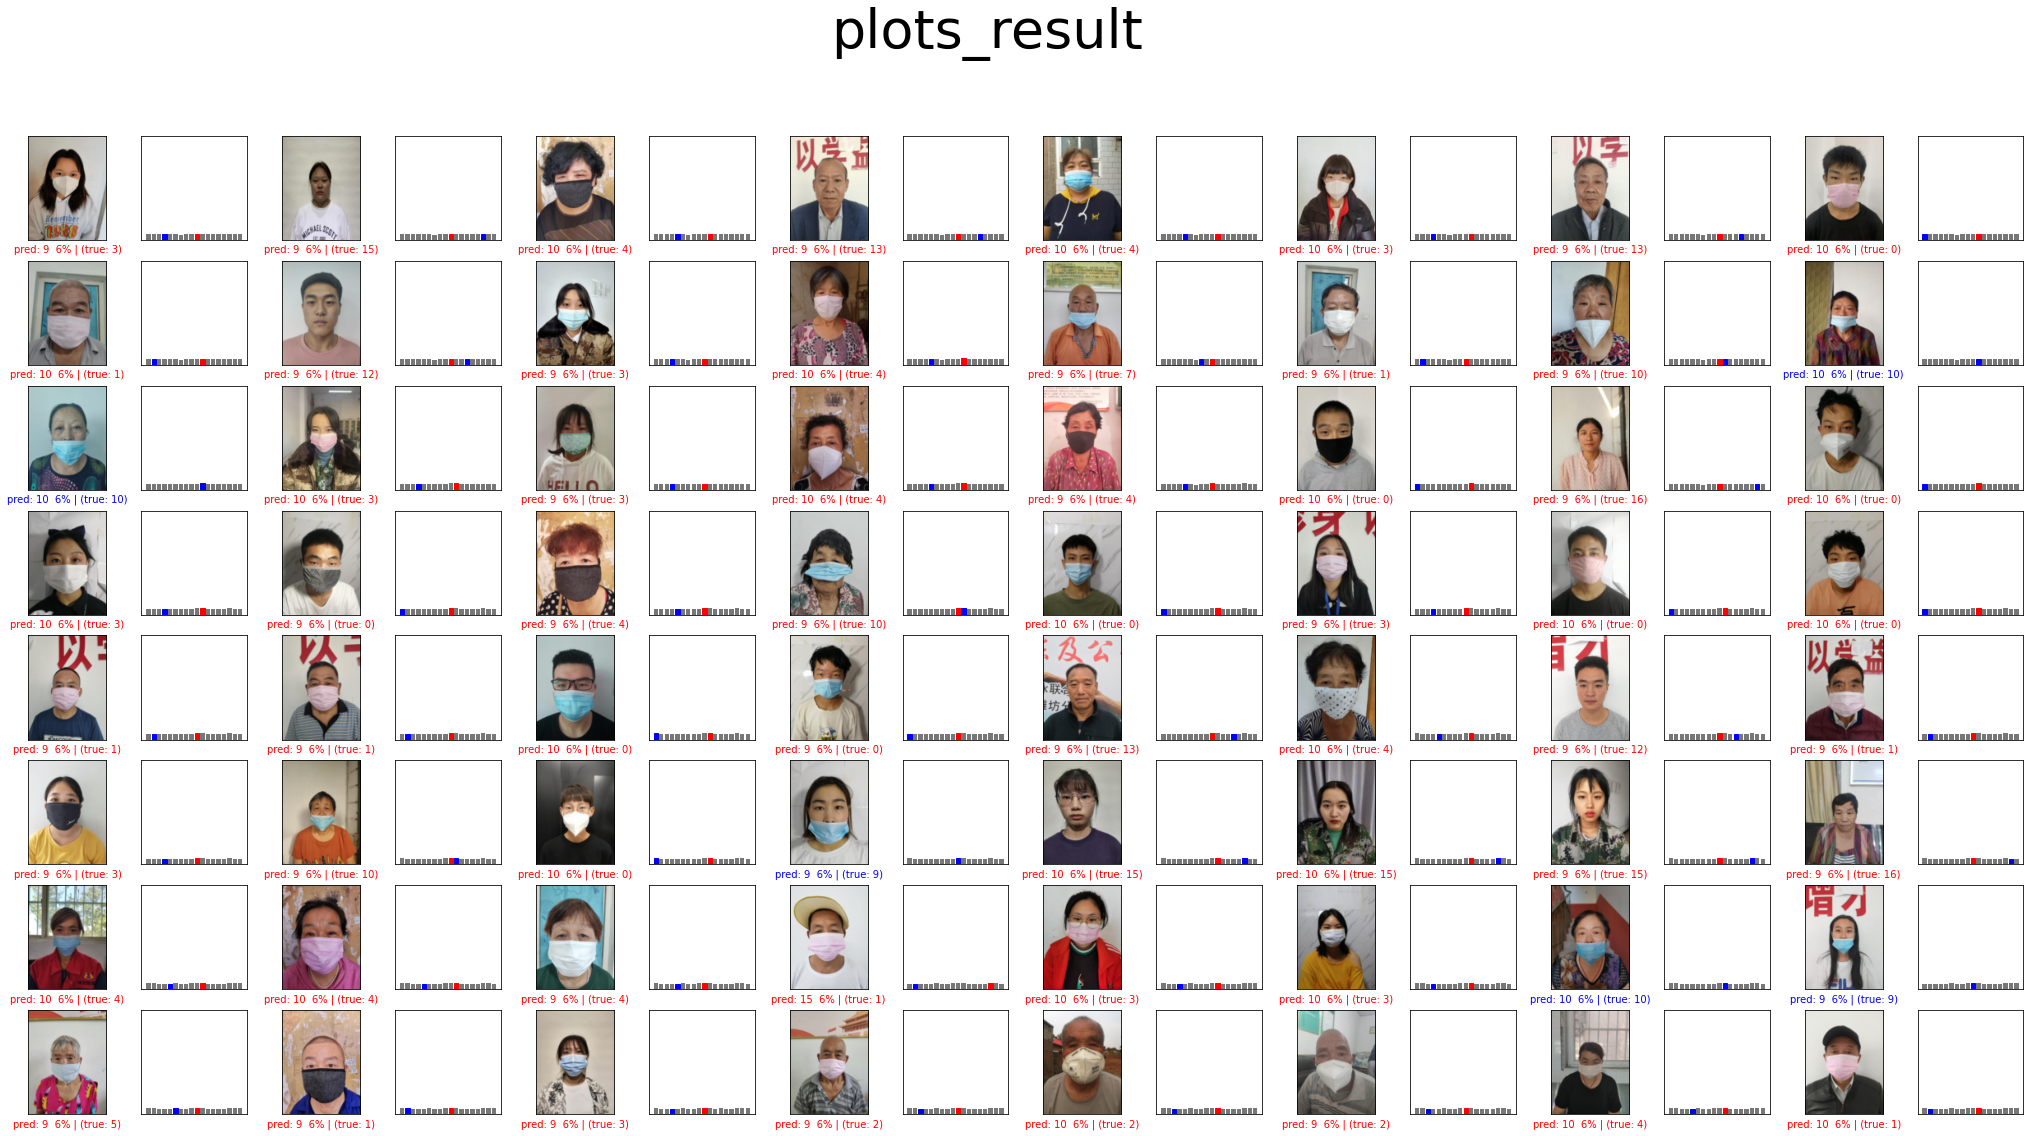

In [17]:
np_images = tensor_images_to_numpy_images(images, renormalize=True)
labels = labels.astype(np.int)

fig = plots_result(np_images[:64], labels[:64], preds[:64], num_classes)

## GradCAM

```bash
pip install pytorch-gradcam
```

In [18]:
from torchvision.models import resnet34

from gradcam.utils import visualize_cam
from gradcam import GradCAMpp

def get_resnet_model(num_classes=18):
    resnet = resnet34(pretrained=True)
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes, bias=True)
    return resnet

def apply_grad_cam_pp_to_images(model, images, device):
    gradcam_pp = GradCAMpp.from_config(
        model_type="resnet", arch=model, layer_name="layer4"
    )

    MEAN = torch.tensor([0.548, 0.504, 0.479]).to(device).reshape(-1, 1, 1)
    STD = torch.tensor([0.237, 0.247, 0.246]).to(device).reshape(-1, 1, 1)

    new_images = torch.empty_like(images).to(device)
    images = torch.clamp((images * STD) + MEAN, 0, 1)

    for idx, image in enumerate(images):
        mask_pp, _ = gradcam_pp(image.unsqueeze(0))
        heatmap_pp, result_pp = visualize_cam(mask_pp, image)
        new_images[idx] = result_pp

    return new_images

In [19]:
model = get_resnet_model(num_classes=18).to(device)

In [20]:
new_images = apply_grad_cam_pp_to_images(model, images[:64], device)

In [21]:
new_np_images = tensor_images_to_numpy_images(new_images)

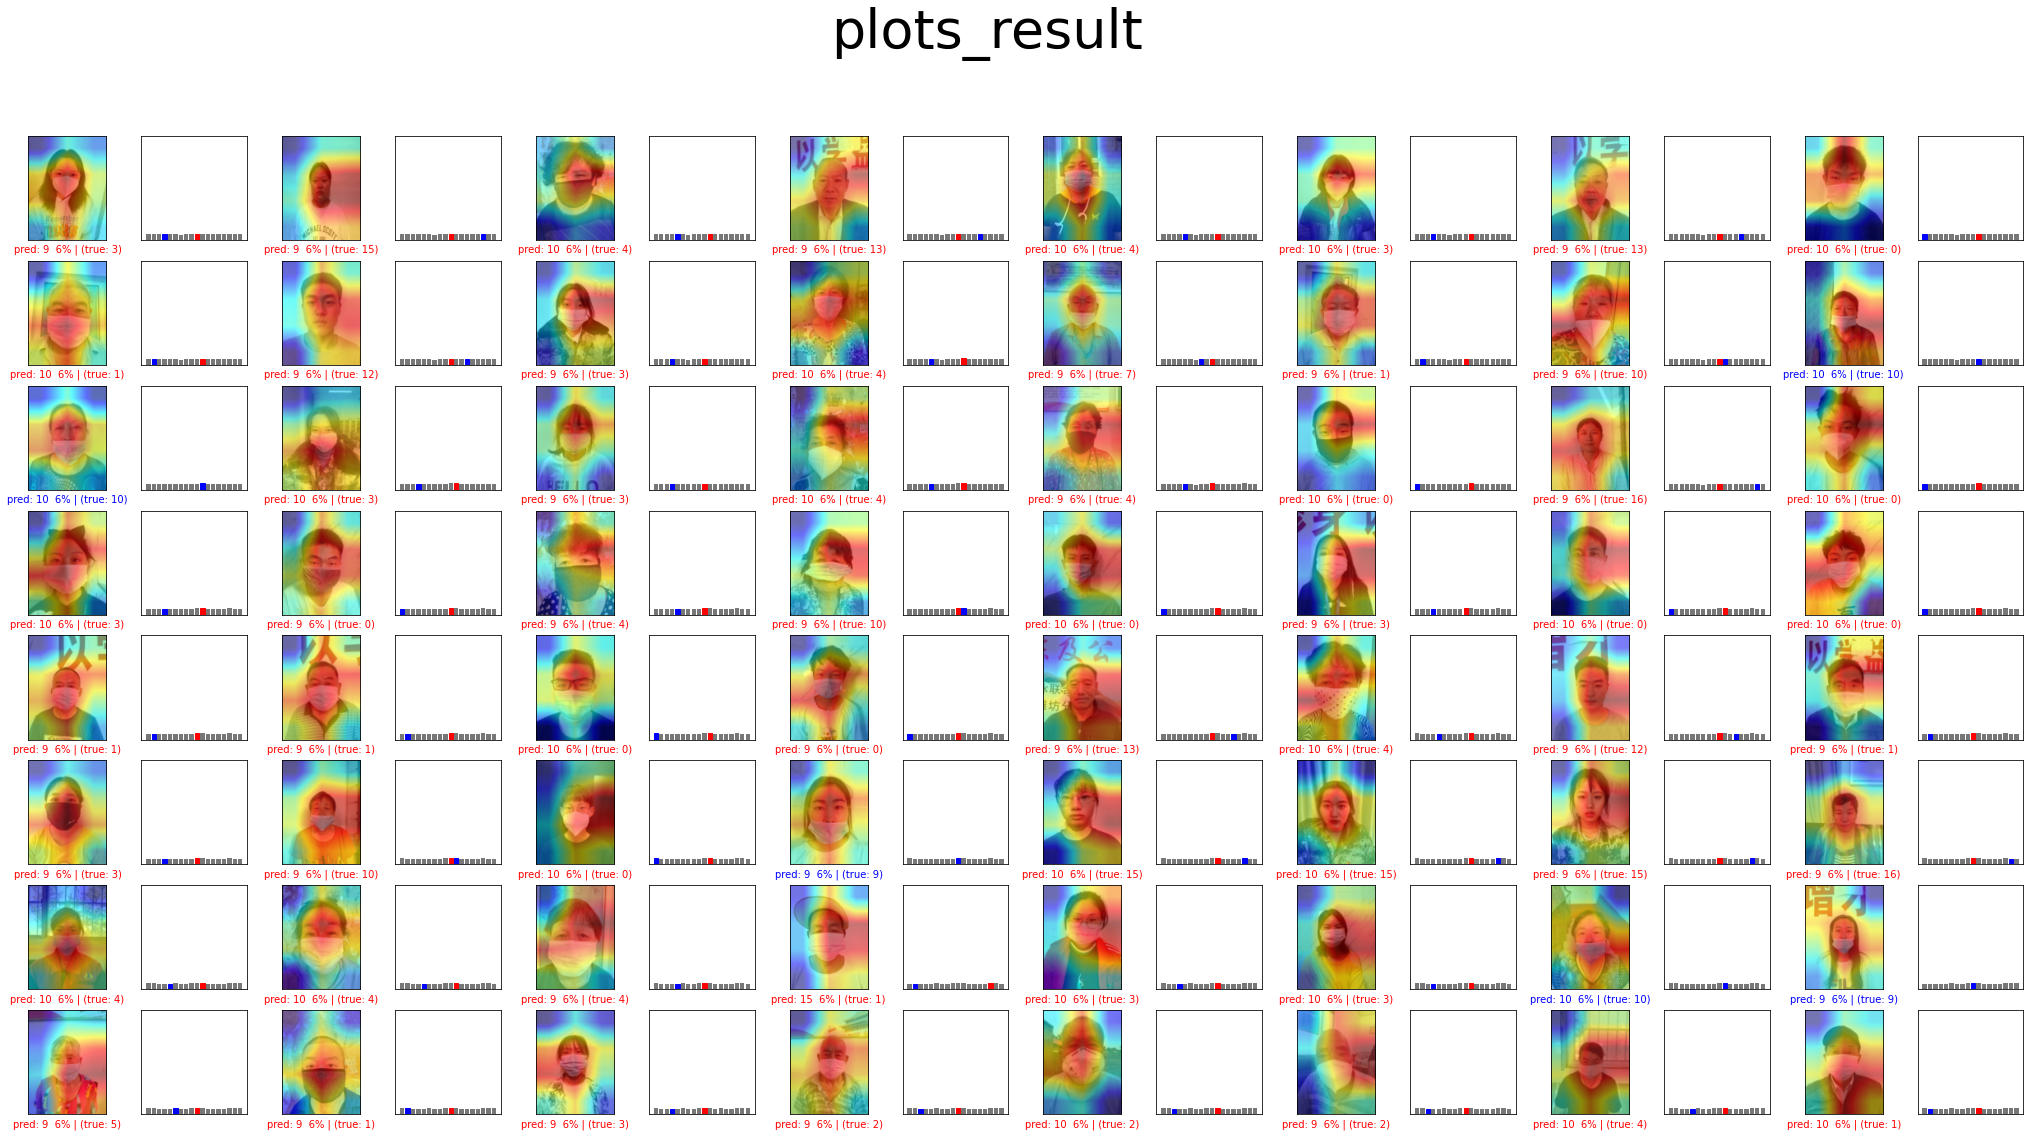

In [22]:
fig = plots_result(new_np_images[:64], labels[:64], preds[:64], num_classes)